# Preprocesamiento

Para responder las hipótesis planteadas se consideraron solamente las tablas de posts, usuarios y tags, eliminando las columnas de identificadores de las tablas  y ejecutando un query se obtuvieron nuevos atributos que se indican acontinuación. 

**1. Características del usuario que responde**

Con la finalidad de determinar la influencia de la reputación y experiencia del usuario que plantea la pregunta se proponen las siguientes características:

El tiempo de respuesta partir de la fecha de creación del post, para ello se utilizaron los atributos: **post_creation_date** y **ans_creation_date** y el resultado es **time_answer**.

* **user_numans**: número de respuestas previo.
* **user_numans_accepted** número de respuestas aceptadas.

Para obtener estos atributos se eliminaron aquellos post que no tienen usuario registrado.

**2. Características de la respuesta**

Además se obtuvieron características del cuerpo dela respuesta  **ans_body**:

* **num_block_code**: cantidad de bloques de código considerando el tag "pre"
* **code_lenght**: número de caracteres en los bloques de código
* **num_i_sentences**: número de oraciones que empiezan con “I”
* **num_wh_words**: número de oraciones que empiezan con  una pregunta. (How, What, etc.)
* **num_words**: número de palabras en el post, eliminando las "top words"
* **num_y_sentences**: número de oraciones que empiezan con “You”. Post que contienen una explicación previa.
* **num_url**: número de links en la respuesta.

Adicionalmente se mantienen algunas de las características obtenidas del dataset como:
* **ans_comment_count**: cantidad de comentarios de la respuesta.
* **post_comment_count**: cantidad de comentarios del post.
* **post_answer_count**: cantidad de respuestas del post.
* **post_view_count**: cantidad de vistas del post.
* **post_favorite_count**: cantidad de marcas como favorito del post.
* **post_score**: score del post.


In [1]:
from bs4 import BeautifulSoup
import pandas as pd

df=pd.read_csv("datos/res-1.csv", usecols=['ans_scoreclass','ans_score','ans_body','ans_comment_count',
    'ans_creation_date','post_comment_count','post_creation_date','post_answer_count',
    'post_view_count','post_favorite_count','post_score','user_numans', 'user_numans_accepted'], quotechar='"')
df.dropna() 
df['post_creation_date']=pd.to_datetime(df['post_creation_date'])
df['ans_creation_date']=pd.to_datetime(df['ans_creation_date'])

In [2]:
df.head()
df.describe()

,ans_comment_count,ans_score,ans_scoreclass,post_comment_count,post_answer_count,post_favorite_count,post_view_count,post_score,user_numans,user_numans_accepted
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000,18000.000000,18000.000000
mean,3.309389,59.113667,1.500000,2.193611,6.089611,32.239722,5.790038e+04,74.820222,1001.435389,492.251611
std,4.344261,175.109821,1.707873,3.071768,17.559212,200.286680,1.691453e+05,298.465389,3229.670355,1845.755485
min,0.000000,-28.000000,-1.000000,0.000000,1.000000,0.000000,7.000000e+00,-147.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,4.160000e+02,1.000000,23.000000,5.000000
50%,2.000000,10.500000,1.500000,1.000000,3.000000,2.000000,6.663000e+03,8.000000,116.000000,37.000000
75%,5.000000,67.000000,3.000000,3.000000,6.000000,16.000000,4.845575e+04,55.000000,563.250000,214.000000
max,64.000000,7031.000000,4.000000,61.000000,518.000000,5556.000000,4.542400e+06,11346.000000,37988.000000,20898.000000


In [3]:
df2 = pd.DataFrame(data=df, index=df.index, columns=['ans_scoreclass','ans_comment_count'
    ,'post_comment_count','post_answer_count','post_view_count',
    'post_favorite_count','post_score','user_numans','user_numans_accepted'])
df2.head()

,ans_scoreclass,ans_comment_count,post_comment_count,post_answer_count,post_view_count,post_favorite_count,post_score,user_numans,user_numans_accepted
0,-1,1,0,1,490,0,3,1602,586
1,-1,0,1,4,347,0,0,14,7
2,-1,1,5,5,1365,0,1,305,148
3,-1,1,0,3,8384,0,2,163,46
4,-1,3,2,6,4831,1,18,10,1


In [4]:
from nltk.corpus import stopwords


#Edad de creacion de la cuenta en relacion al post en dias.
df2['time_answer'] = (df['ans_creation_date'] - df['post_creation_date']).fillna(0).astype('timedelta64[D]')
df2['num_block_code'] = 0
df2["num_i_sentences"]=0
df2["num_wh_words"]=0
df2["num_y_sentences"]=0

whwords=['what','how', 'which', 'when', 'why', 'where']
for index, row in df.iterrows():
    sbody=row["ans_body"]
    soup = BeautifulSoup(sbody, "html5lib")
    sentences =  soup.find_all(name="p")
    urls =  soup.find_all('a', href=True)
    #Questions words
    count_wh=0
    #Oraciones que tienen el pronombre I
    count_is=0
    #Oraciones que tienen el pronombre You
    count_ys = 0
    palabras=[]
    filtered_words=[]
    for sentence in sentences:
        try:
            palabras=sentence.contents[0].split()
        except:
            palabras=str(sentence.contents).split() 
        if(len(palabras)==0):
            children = soup.find_all("li", { "class" : "expandable" }, recursive=False)
            for child in children:
                palabras.extend(child.getText().split())
        filtered_words.extend([word for word in palabras if word not in stopwords.words('english')])
        count_is=count_is+len([x for x in palabras if x == "I"])
        count_is=count_is+len([x for x in palabras if len(x.split("I'"))>1])    
        count_ys=count_ys+len([x for x in palabras if x == "You"])
        count_ys=count_ys+len([x for x in palabras if len(x.split("You'"))>1])
        for word in whwords:
            count_wh=count_wh+len([x for x in palabras if x == word])
    df2.loc[index, "num_i_sentences"] = count_is
    df2.loc[index, "num_wh_words"] = count_wh
    df2.loc[index, "num_y_sentences"] = count_ys    
    df2.loc[index, "num_words"] = len(filtered_words)
    df2.loc[index, "num_url"]=len(urls)

In [5]:
df2.head()

,ans_scoreclass,ans_comment_count,post_comment_count,post_answer_count,post_view_count,post_favorite_count,post_score,user_numans,user_numans_accepted,time_answer,num_block_code,num_i_sentences,num_wh_words,num_y_sentences,num_words,num_url
0,-1,1,0,1,490,0,3,1602,586,0.0,0,0,0,1,12.0,0.0
1,-1,0,1,4,347,0,0,14,7,64.0,0,2,0,0,15.0,1.0
2,-1,1,5,5,1365,0,1,305,148,0.0,0,0,0,0,9.0,2.0
3,-1,1,0,3,8384,0,2,163,46,0.0,0,0,0,0,13.0,1.0
4,-1,3,2,6,4831,1,18,10,1,0.0,0,0,0,0,12.0,0.0


In [6]:
#Caracteristicas del codigo y tags
import string

for index, row in df.iterrows():
    body=row["ans_body"]
    soup = BeautifulSoup(body, "html5lib")
    precode = soup.find_all("pre")
    df2.loc[index, "num_block_code"]=len(precode)
    content=""
    for codeline in precode:
        contentPre = codeline.contents
        for contentCode in contentPre:
            try:
                content=content+contentCode.contents[0]
            except :
                try:
                    content = content + str(contentCode)
                except:
                    print(contentCode)
    wordCodeCount =len(content)
    df2.loc[index,"code_length"]=wordCodeCount    
df2.head()

,ans_scoreclass,ans_comment_count,post_comment_count,post_answer_count,post_view_count,post_favorite_count,post_score,user_numans,user_numans_accepted,time_answer,num_block_code,num_i_sentences,num_wh_words,num_y_sentences,num_words,num_url,code_length
0,-1,1,0,1,490,0,3,1602,586,0.0,0,0,0,1,12.0,0.0,0.0
1,-1,0,1,4,347,0,0,14,7,64.0,1,2,0,0,15.0,1.0,109.0
2,-1,1,5,5,1365,0,1,305,148,0.0,1,0,0,0,9.0,2.0,517.0
3,-1,1,0,3,8384,0,2,163,46,0.0,1,0,0,0,13.0,1.0,182.0
4,-1,3,2,6,4831,1,18,10,1,0.0,0,0,0,0,12.0,0.0,0.0


In [7]:
num_features = [
 'ans_comment_count',
 'post_comment_count',
 'post_answer_count',
 'post_view_count',
 'post_favorite_count',
 'post_score',
 'user_numans',
 'user_numans_accepted',
 'time_answer',
 'num_block_code',
 'num_i_sentences',
 'num_wh_words',
 'num_y_sentences',
 'num_words',
 'num_url',
 'code_length']
df_statistics=pd.DataFrame(index=num_features)
for index, row in df_statistics.iterrows():
    df_statistics.loc[index,"min"]=df2[index].min()
    df_statistics.loc[index,"max"] = df2[index].max()
    df_statistics.loc[index,"mean"] = df2[index].mean()
    df_statistics.loc[index,"std"] = df2[index].std()
    df_statistics.loc[index,"var"] = df2[index].var()
df_statistics

,min,max,mean,std,var
ans_comment_count,0.0,64.0,3.309389,4.344261,1.887260e+01
post_comment_count,0.0,61.0,2.193611,3.071768,9.435761e+00
post_answer_count,1.0,518.0,6.089611,17.559212,3.083259e+02
post_view_count,7.0,4542400.0,57900.378778,169145.260142,2.861012e+10
post_favorite_count,0.0,5556.0,32.239722,200.286680,4.011475e+04
post_score,-147.0,11346.0,74.820222,298.465389,8.908159e+04
user_numans,0.0,37988.0,1001.435389,3229.670355,1.043077e+07
user_numans_accepted,0.0,20898.0,492.251611,1845.755485,3.406813e+06
time_answer,-995.0,3037.0,126.932833,354.788815,1.258751e+05
num_block_code,0.0,27.0,1.124722,1.499060,2.247180e+00


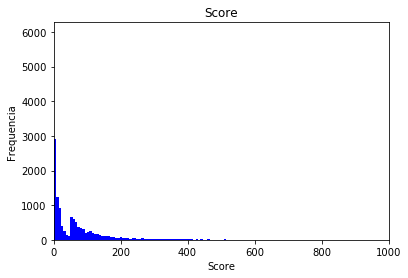

In [8]:
import matplotlib.pyplot as plt
plt.hist(df['ans_score'], bins=1000, color="blue")
plt.xlim(xmin=0, xmax=1000)
plt.title("Score")
plt.ylabel("Frequencia")
plt.xlabel("Score")
plt.show()

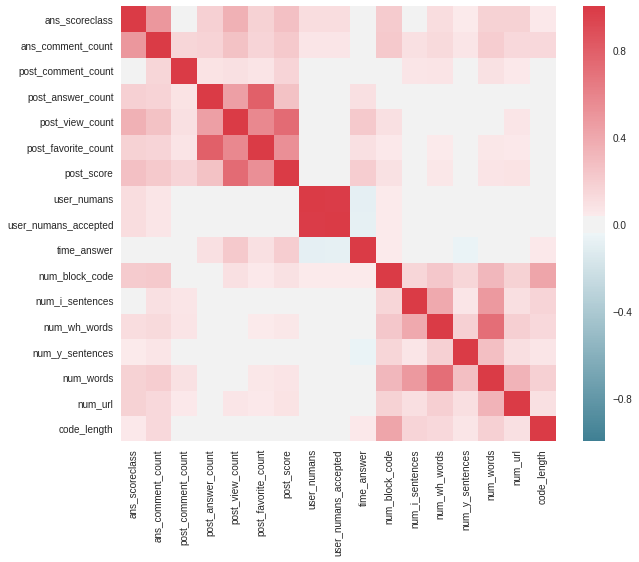

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
f, ax = plt.subplots(figsize=(10, 8))
corr = df2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [10]:
for each in num_features:
    mean, std = df2[each].mean(), df2[each].std()
    df2.loc[:, each] = (df2[each] - mean)/std
df2.describe()

,ans_scoreclass,ans_comment_count,post_comment_count,post_answer_count,post_view_count,post_favorite_count,post_score,user_numans,user_numans_accepted,time_answer,num_block_code,num_i_sentences,num_wh_words,num_y_sentences,num_words,num_url,code_length
count,18000.000000,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04
mean,1.500000,-2.555920e-14,6.319760e-16,-8.189267e-15,-6.043545e-16,-1.214444e-15,-6.532127e-15,7.454716e-16,-1.503581e-16,4.307881e-15,1.674399e-14,-1.731831e-15,8.819180e-15,-8.780631e-17,3.205362e-15,1.300578e-14,-5.404171e-15
std,1.707873,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.000000,-7.617841e-01,-7.141200e-01,-2.898542e-01,-3.422702e-01,-1.609679e-01,-7.432025e-01,-3.100736e-01,-2.666938e-01,-3.162255e+00,-7.502851e-01,-4.239193e-01,-4.255939e-01,-4.868442e-01,-6.411933e-01,-4.148846e-01,-3.779192e-01
25%,0.000000,-7.617841e-01,-7.141200e-01,-2.329040e-01,-3.398521e-01,-1.609679e-01,-2.473326e-01,-3.029521e-01,-2.639849e-01,-3.577701e-01,-7.502851e-01,-4.239193e-01,-4.255939e-01,-4.868442e-01,-4.785106e-01,-4.148846e-01,-3.779192e-01
50%,1.500000,-3.014066e-01,-3.885746e-01,-1.759539e-01,-3.029194e-01,-1.509822e-01,-2.238793e-01,-2.741566e-01,-2.466478e-01,-3.577701e-01,-8.320030e-02,-4.239193e-01,-4.255939e-01,-4.868442e-01,-2.751573e-01,-4.148846e-01,-2.734890e-01
75%,3.000000,3.891596e-01,2.625162e-01,-5.103367e-03,-5.583738e-02,-8.108239e-02,-6.640710e-02,-1.356750e-01,-1.507522e-01,-3.521330e-01,5.838845e-01,3.751746e-01,4.482159e-01,-4.868442e-01,1.112139e-01,2.167590e-01,1.403321e-02
max,4.000000,1.397030e+01,1.914415e+01,2.915338e+01,2.651271e+01,2.757927e+01,3.776377e+01,1.145212e+01,1.105550e+01,8.202252e+00,1.726100e+01,2.354890e+01,2.141965e+01,2.644576e+01,2.717754e+01,2.611415e+01,3.504970e+01


In [11]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier


In [25]:
X = df2.iloc[:,1:]
y = df2.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3000,random_state=10)
dummyclf= DummyClassifier(strategy="stratified", random_state=10)
dummyclf.fit(X_train, y_train)
y_pred = dummyclf.predict(X_test)
print ("Dummy Classifier")
print(classification_report(y_test, y_pred))

clf=DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print ("Decision Tree")
print(classification_report(y_test, y_pred))




Dummy Classifier
             precision    recall  f1-score   support

         -1       0.14      0.14      0.14       467
          0       0.18      0.16      0.17       530
          1       0.15      0.15      0.15       527
          2       0.15      0.16      0.15       484
          3       0.19      0.17      0.18       506
          4       0.15      0.17      0.16       486

avg / total       0.16      0.16      0.16      3000

Decision Tree
             precision    recall  f1-score   support

         -1       0.37      0.37      0.37       467
          0       0.42      0.39      0.40       530
          1       0.38      0.39      0.39       527
          2       0.51      0.55      0.53       484
          3       0.52      0.49      0.50       506
          4       0.64      0.64      0.64       486

avg / total       0.47      0.47      0.47      3000



In [22]:
df_ans=pd.DataFrame(data=df2, columns=['ans_scoreclass','ans_comment_count',
 'user_numans',
 'user_numans_accepted',
 'time_answer',
 'num_block_code',
 'num_i_sentences',
 'num_wh_words',
 'num_y_sentences',
 'num_words',
 'num_url',
 'code_length'], index=df2.index)

X = df_ans.iloc[:,1:]
y = df_ans.iloc[:,0]

clf=DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3000,random_state=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print ("Decision Tree")
print(classification_report(y_test, y_pred))


Decision Tree
             precision    recall  f1-score   support

         -1       0.33      0.34      0.33       467
          0       0.29      0.27      0.28       530
          1       0.25      0.26      0.25       527
          2       0.20      0.20      0.20       484
          3       0.23      0.23      0.23       506
          4       0.33      0.34      0.33       486

avg / total       0.27      0.27      0.27      3000



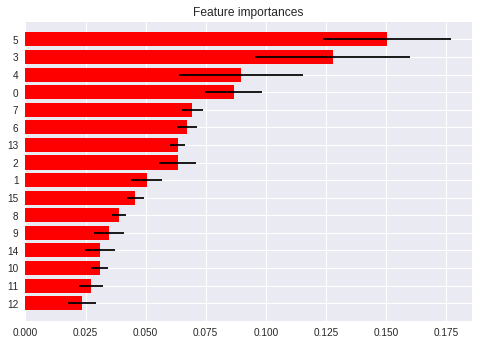

In [18]:
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")

plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

In [158]:
list(df2)

['ans_scoreclass',
 'ans_comment_count',
 'post_comment_count',
 'post_answer_count',
 'post_view_count',
 'post_favorite_count',
 'post_score',
 'user_numans',
 'user_numans_accepted',
 'time_answer',
 'num_block_code',
 'num_i_sentences',
 'num_wh_words',
 'num_y_sentences',
 'num_words',
 'num_url',
 'code_length']